# Цветовые схемы. Преобразования цветовых схем.

In [1]:
#import matplotlib
#matplotlib.use('qt5agg')
#%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

import random
import pathlib

from matplotlib.colors import LinearSegmentedColormap

 *Преобразования в разные цветовые схемы: RGB, CMYK, HSV, CIE YCbCr*

\begin{equation}
e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i
\end{equation}

_**Inline formula:**_ $e^{i\pi} + 1 = 0$

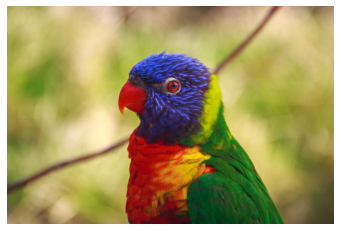

In [2]:
path = "img/medium"
collection = images = [p for p in pathlib.Path(path).iterdir() if p.suffix in [".jpg", ".jpeg"]]
img = plt.imread(random.choice(collection))

#figure, axes = plt.subplots()
plt.imshow(img, cmap='hsv')
plt.axis('off')
plt.show()

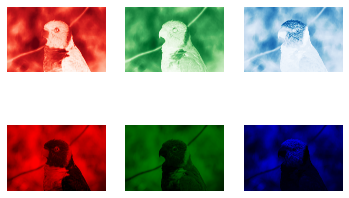

In [3]:
colormaps = [
    ["Reds", "Greens", "Blues"],
    [
        LinearSegmentedColormap.from_list("BkR", ["Black", "Red"]),
        LinearSegmentedColormap.from_list("BkG", ["Black", "Green"]),
        LinearSegmentedColormap.from_list("BkBu", ["Black", "Blue"])
    ],
]

for cm in range(len(colormaps)):
    for ch in range(len(colormaps[cm])):
        plt.subplot(2, 3, cm*3 + ch+1).imshow(img[:, :, ch], cmap=colormaps[cm][ch])

for axes in plt.gcf().findobj(plt.Axes):
    axes.set_axis_off()
plt.show()

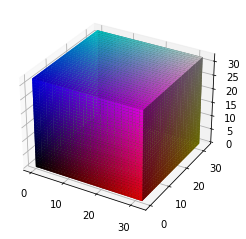

In [4]:
# RGB cube
granularity = 8
edge_len= int(256 / granularity)
space = np.indices((edge_len, edge_len, edge_len))
cube = (space[0] < edge_len) & (space[1] < edge_len) & (space[2] < edge_len)

colors = np.transpose(space, (1, 2, 3, 0)) / edge_len
plt.figure().add_subplot(projection='3d').voxels(cube, facecolors=colors, linewidth=0.5)
plt.show()

In [5]:
#CMY cube
plt.figure().add_subplot(projection='3d').voxels(cube, facecolors=(1 - colors), linewidth=0.5)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

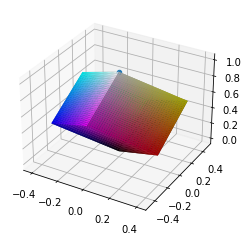

In [5]:
import scipy.spatial.transform.rotation
#cube_rotation = scipy.spatial.transform.Rotation.from_euler("XY", (35, -45), degrees=True)
#cube_rotation = scipy.spatial.transform.Rotation.from_euler("xy", (45, -35), degrees=True)
cube_rotation = scipy.spatial.transform.Rotation.from_euler("xyz", (np.pi / 4, -np.arctan(1/np.sqrt(2)), -np.pi/6))
grid = np.transpose(np.indices((edge_len + 1, edge_len + 1, edge_len + 1)) / edge_len / np.sqrt(3), (1, 2, 3, 0))
hsv_space = np.reshape(cube_rotation.apply(np.reshape(grid, newshape=(-1, 3))), grid.shape)

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(hsv_space[..., 0], hsv_space[..., 1], hsv_space[..., 2], cube, facecolors=colors, linewidth=0.5)
ax.scatter([0], [0], [1.0], marker='o')
plt.show()

[12 30 10]
[12 30 11]
[11 30 11]
[11 30 11]
[11 30 12]
[10 30 12]
[10 12 30]
[11 11 30]
[11 11 30]
[12 11 30]
[30 11 12]
[30 11 11]
[30 11 11]
[30 12 10]
[14 30 10]
[14 30 10]
[14 30 11]
[13 30 10]
[13 30 11]
[13 31 11]
[13 30 12]
[12 30 11]
[12 31 11]
[12 30 12]
[12 31 12]
[11 31 11]
[12 30 13]
[11 30 12]
[11 31 12]
[11 30 13]
[11 31 13]
[11 30 14]
[10 30 13]
[10 30 14]
[10 30 14]
[10 14 30]
[10 14 30]
[11 13 30]
[11 13 30]
[11 13 30]
[11 12 31]
[12 12 30]
[11 12 30]
[11 12 31]
[12 12 30]
[12 12 30]
[12 11 31]
[13 12 30]
[13 11 30]
[12 11 31]
[13 11 30]
[13 11 30]
[14 11 30]
[13 10 30]
[14 10 30]
[15 10 30]
[30 10 15]
[30 10 14]
[30 11 14]
[30 10 13]
[30 11 13]
[30 11 13]
[30 12 13]
[30 11 13]
[31 11 12]
[30 12 12]
[30 12 12]
[31 11 12]
[30 12 12]
[30 12 11]
[31 12 11]
[30 13 11]
[31 12 11]
[30 13 11]
[30 13 11]
[30 14 10]
[30 14 10]


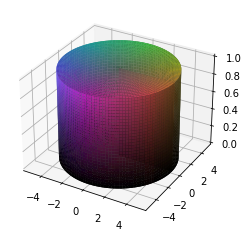

In [64]:
cylinder_shape = (
    complex(int(180 / granularity), 1),
    complex(int((180 / granularity) * 2 * np.pi), 1),
    complex(int(edge_len), 1)
    #complex(int(edge_len * np.sqrt(3)), 1)
)
cylinder_size = (5.0, 2*np.pi, 1.0)
cylinder_grid = np.mgrid[0:cylinder_size[0]:cylinder_shape[0], 0:cylinder_size[1]:cylinder_shape[1], 0:cylinder_size[2]:cylinder_shape[2]]
corners = np.array(hsv_space[0:2, 0:2, 0:2, :] * edge_len).reshape((-1, 3))
order = [0, 1, 3, 7, 6, 4, 0, 1]
planes = np.zeros(shape=(6, 4), dtype=np.float64)

for p in range(len(order) - 2):
    #print(f"{p+1}.\t{order[p]}. {corners[order[p]]}\n\t{order[p+1]}. {corners[order[p+1]]}\n\t{order[p+2]}. {corners[order[p+2]]}")
    planes[p][0:3] = np.cross(corners[order[p]] - corners[order[p+1]], corners[order[p+2]] - corners[order[p+1]])
    planes[p][3] = -np.sum(planes[p][0:3] * corners[order[p+1]])

equations = np.zeros(shape=(6, 3, 4))
equations[:, 0, :] = planes
#cylinder = ((cylinder_grid[0] * np.cos(cylinder_grid[1])) ** 2 + (cylinder_grid[0] * np.sin(cylinder_grid[1])) ** 2 < 0.25)
cylinder = cylinder_grid[0] < cylinder_size[0]
cylinder_grid = cylinder_grid.transpose((1, 2, 3, 0))
cylinder_colors = np.zeros(shape=cylinder_grid.shape)
for h in range(int(cylinder_shape[2].real)):
    equations[:, 1, :] =  np.array([0, 0, 1, cylinder_grid[0][0][h][2]])
    for t in range(int(cylinder_shape[1].real)):
        equations[:, 2, :] = np.array([np.cos(cylinder_grid[0][t][h][1]), np.sin(cylinder_grid[0][t][h][1]), 0, 0])
        temp = np.linalg.solve(equations[:, :, 0:3], equations[:, :, 3])
        d = np.amin(np.linalg.norm(temp - [0, 0, cylinder_grid[0][0][h][2]], axis=1))
        rate = 0.62 * d / cylinder_size[0]
        for r in range(int(cylinder_shape[0].real)):
            index = cube_rotation.apply(np.array([
                cylinder_grid[r][t][h][0]*rate*np.cos(cylinder_grid[r][t][h][1]),
                cylinder_grid[r][t][h][0]*rate*np.sin(cylinder_grid[r][t][h][1]),
                cylinder_grid[r][t][h][2]
            ]), inverse=True)*edge_len
            index = index.astype(int)
            cylinder_colors[r][t][h] = colors[index[0]][index[1]][index[2]]
            if np.any(index > 29):
                print(f"{index}")

plt.figure().add_subplot(projection='3d')\
    .voxels(cylinder_grid[..., 0] * np.cos(cylinder_grid[..., 1]), cylinder_grid[..., 0] * np.sin(cylinder_grid[..., 1]), cylinder_grid[..., 2], cylinder[:-1, :-1, :-1], facecolors=cylinder_colors[1:, 1:, 1:, :])
plt.show()